# K-means clustering

In [243]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, MaxAbsScaler, QuantileTransformer, Normalizer   # this is to normalize data before applying Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy import stats
from sklearn.manifold import TSNE

import datetime as dt

import feature_engine
from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px

%matplotlib ipympl


In [244]:
rfm_v_data = pd.read_csv(r'C:\Users\argyr\OneDrive\Υπολογιστής\Diplvm\Giftware dataset\rfm_values.csv')
rfm_v_data.head()

,Customer ID,Recency,Frequency,Monetary
0,12346,432.0,34.0,368.36
1,12347,3.0,222.0,4921.53
2,12348,76.0,51.0,2019.40
3,12349,19.0,179.0,4419.49
4,12350,311.0,17.0,334.40


**K-means** gives the best result under the following conditions:

~ **Data’s distribution is not skewed** (i.e. long-tail distribution).

~ **Data is standardised** (i.e. mean of 0 and standard deviation of 1).

In [245]:
# Plotting distribution charts to check for skewness.

# Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 0.9000801089965867, : SkewtestResult(statistic=24.307009211824568, pvalue=1.6528021849915005e-130)
Frequency's: Skew: 18.15132571603897, : SkewtestResult(statistic=97.00151088116074, pvalue=0.0)
Monetary's: Skew: 26.64341223026506, : SkewtestResult(statistic=106.8092076660042, pvalue=0.0)


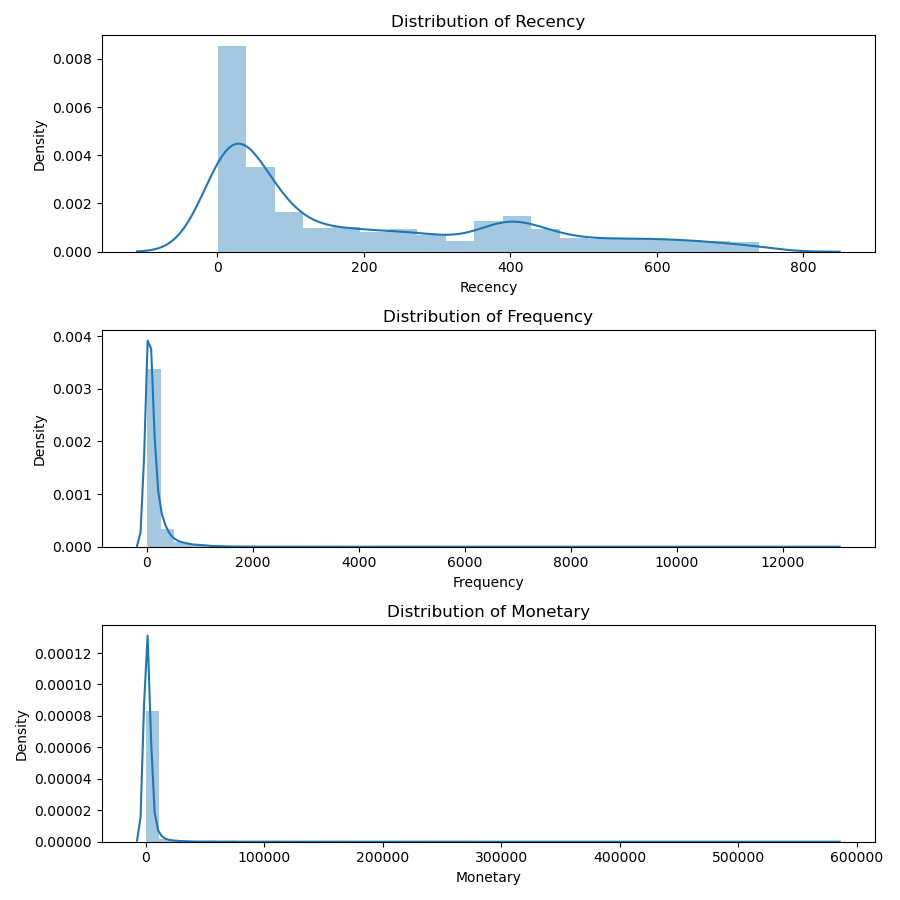

In [246]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm_v_data,'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm_v_data,'Frequency')

plt.subplot(3, 1, 3)
check_skew(rfm_v_data,'Monetary')

plt.tight_layout()

The data is **highly skewed**,therefore we will perform **log transformations to reduce the skewness of each variable**. I added a small constant as log transformation demands all the values to be positive.

In [247]:
df_rfm_log = rfm_v_data.copy()

Recency's: Skew: -0.5404164723129773, : SkewtestResult(statistic=-15.857245659750317, pvalue=1.2526850021892315e-56)
Frequency's: Skew: -0.21608793139850074, : SkewtestResult(statistic=-6.678633877170599, pvalue=2.4117984621932063e-11)
Monetary's: Skew: -0.49372365637530247, : SkewtestResult(statistic=-14.623459595422942, pvalue=1.9902454187696046e-48)


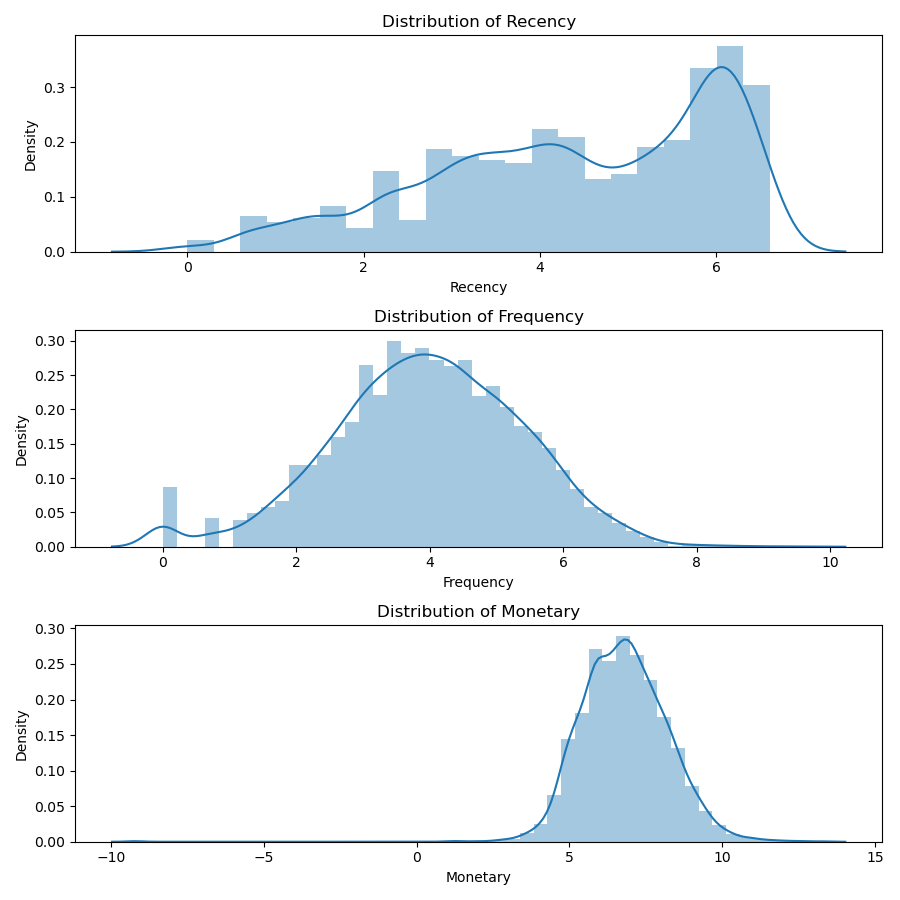

In [248]:
df_rfm_log = np.log(df_rfm_log+0.0001)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [249]:
rfm_v_data.describe()

,Customer ID,Recency,Frequency,Monetary
count,5848.000000,5848.000000,5848.000000,5848.000000
mean,15317.902360,199.509576,136.954343,2837.559219
std,1715.310306,208.753331,353.715015,13896.008287
min,12346.000000,1.000000,1.000000,0.000000
25%,13836.750000,25.000000,21.000000,339.535000
50%,15318.500000,93.000000,53.000000,858.885000
75%,16799.250000,379.000000,142.000000,2207.415000
max,18287.000000,739.000000,12887.000000,578408.640000


In [250]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [251]:
df_rfm_log = windsoriser.transform(df_rfm_log)

Once the skewness is reduced, I standardised the data by centring and scaling. Note all the variables now have a mean of 0 and a standard deviation of 1.

In [252]:
# scaler = MinMaxScaler() # not good
#scaler = StandardScaler() # ok
# PowerTransformer() works with Invoice.count() without mean monetary value
scaler = PowerTransformer()

scaler.fit(df_rfm_log)

rfm_v_data_scaled = scaler.transform(df_rfm_log)

In [253]:
rfm_v_data_scaled = pd.DataFrame(rfm_v_data_scaled, columns=df_rfm_log.columns)
rfm_v_data_scaled.head()

,Customer ID,Recency,Frequency,Monetary
0,-1.764161,1.090939,-0.334028,-0.651536
1,-1.763544,-1.843212,1.054807,1.280657
2,-1.762928,-0.139526,-0.035171,0.643092
3,-1.762312,-0.980278,0.894745,1.204929
4,-1.761696,0.844289,-0.843014,-0.728673


Recency's: Skew: -0.2233593527872367, : SkewtestResult(statistic=-6.898154570643898, pvalue=5.2682408044362494e-12)
Frequency's: Skew: -0.05846976410911575, : SkewtestResult(statistic=-1.8261869841814857, pvalue=0.06782210123892791)
Monetary's: Skew: -0.018437805192532797, : SkewtestResult(statistic=-0.5763090373328916, pvalue=0.5644063154218186)


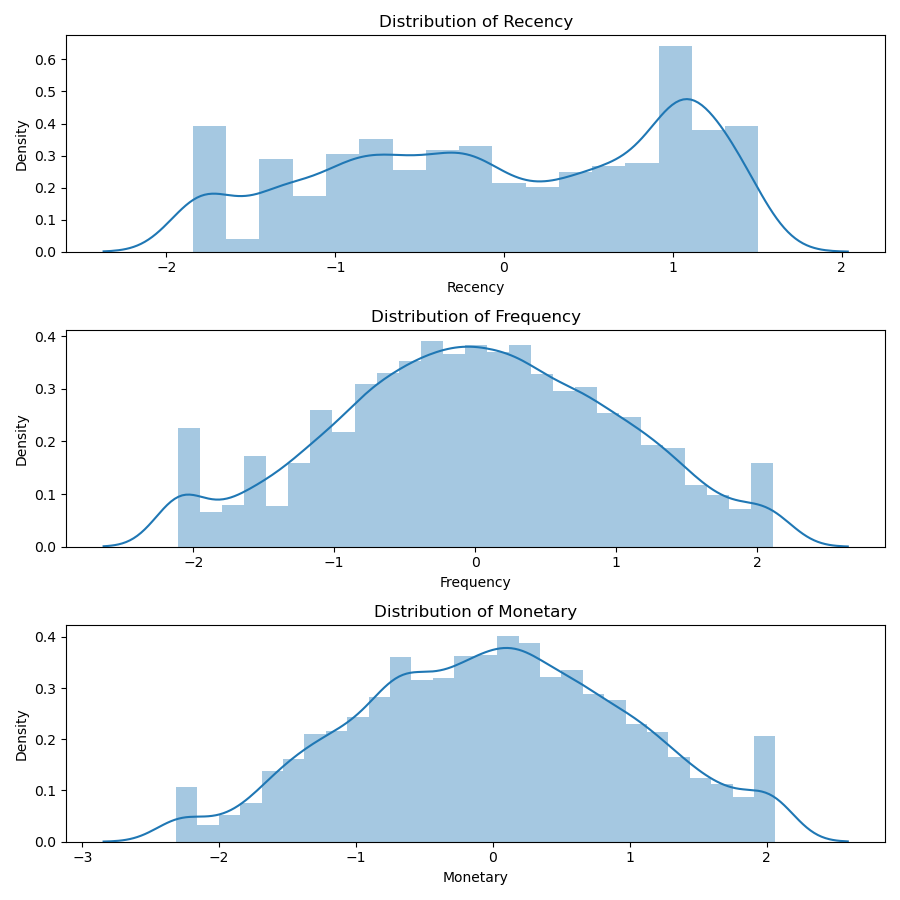

In [254]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm_v_data_scaled,'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm_v_data_scaled,'Frequency')
plt.subplot(3, 1, 3)
check_skew(rfm_v_data_scaled,'Monetary')

plt.tight_layout()

## K-Means Clustering

### Finding the optimal number of clusters

In [255]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(rfm_v_data_scaled) 
    #kmeanModel.fit(rfm_v_data_scaled)     
      
    distortions.append(sum(np.min(cdist(rfm_v_data_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / rfm_v_data_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(rfm_v_data_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / rfm_v_data_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

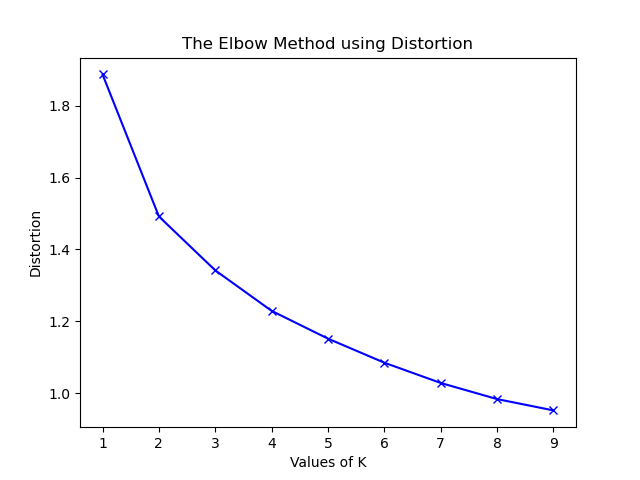

In [256]:
plt.figure()
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

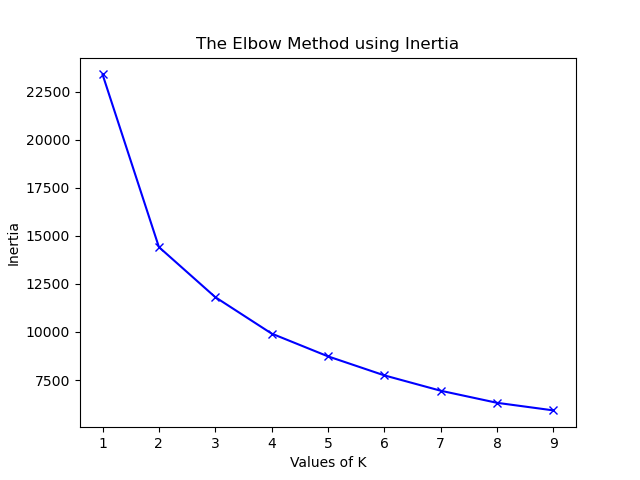

In [257]:
plt.figure()
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


##### The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 4 to 7.


In [258]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    
    return df_new

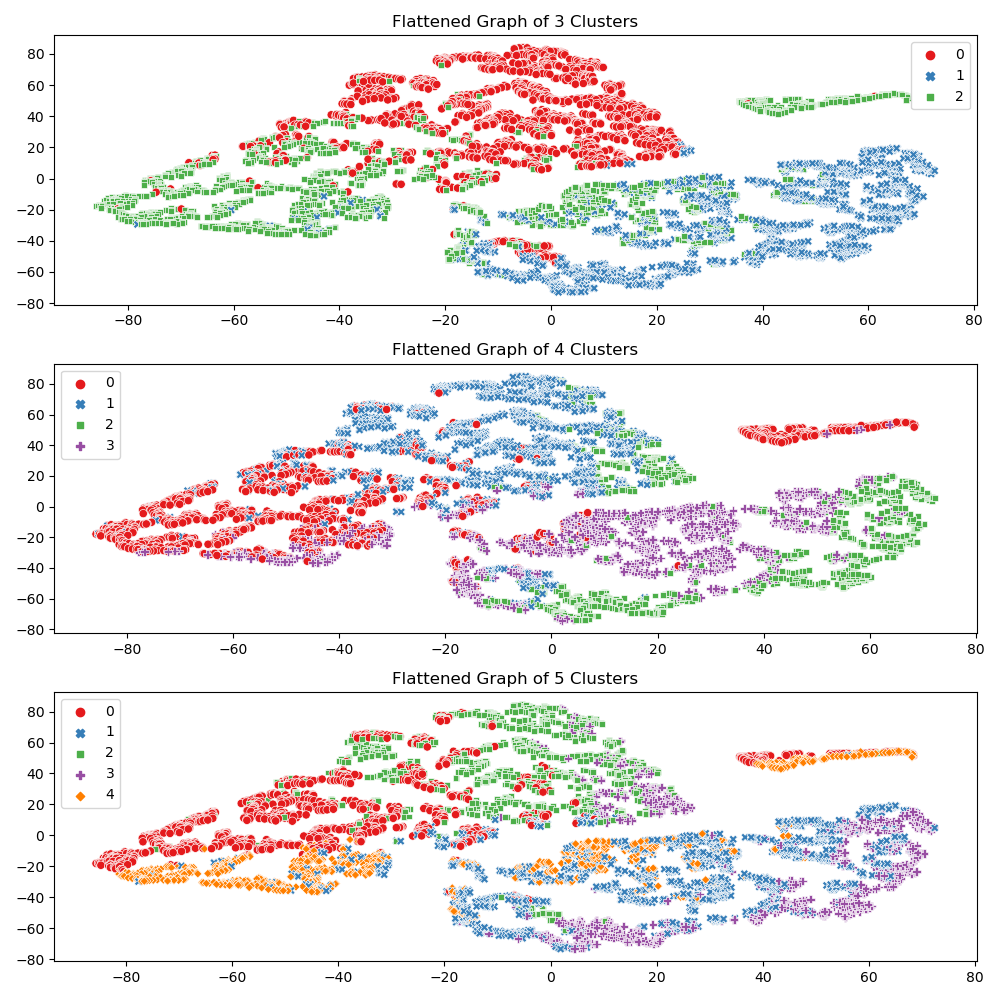

In [259]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(rfm_v_data_scaled, 3, rfm_v_data)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(rfm_v_data_scaled, 4, rfm_v_data)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(rfm_v_data_scaled, 5, rfm_v_data)

plt.tight_layout()

In [260]:
# Plot the clusters in 3D
def scatter_clusters_3d(rfm_v_data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        rfm_v_data['Recency'], rfm_v_data['Frequency'], rfm_v_data['Monetary'],
        c=rfm_v_data['Cluster'], cmap='jet', marker='o'
    )

    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.set_title('RFM Clusters')



    # Add legend
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    plt.show()

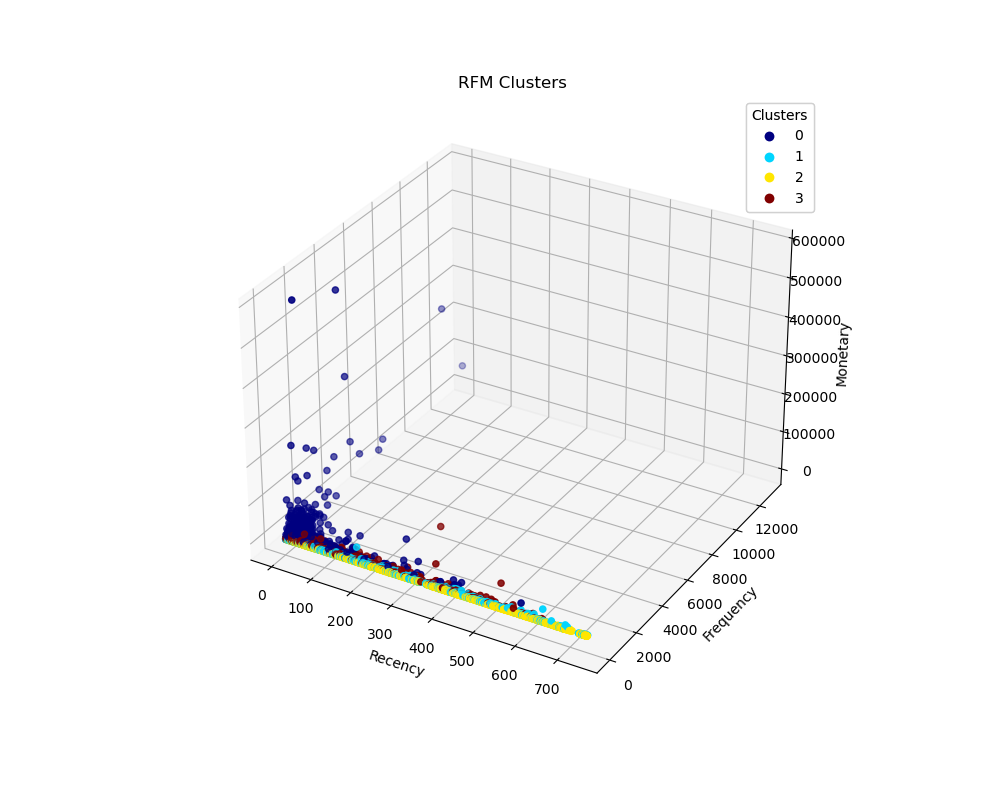

In [261]:
scatter_clusters_3d(df_rfm_k4)

In [262]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=rfm_v_data.index, 
                                       columns=rfm_v_data.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['Customer ID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

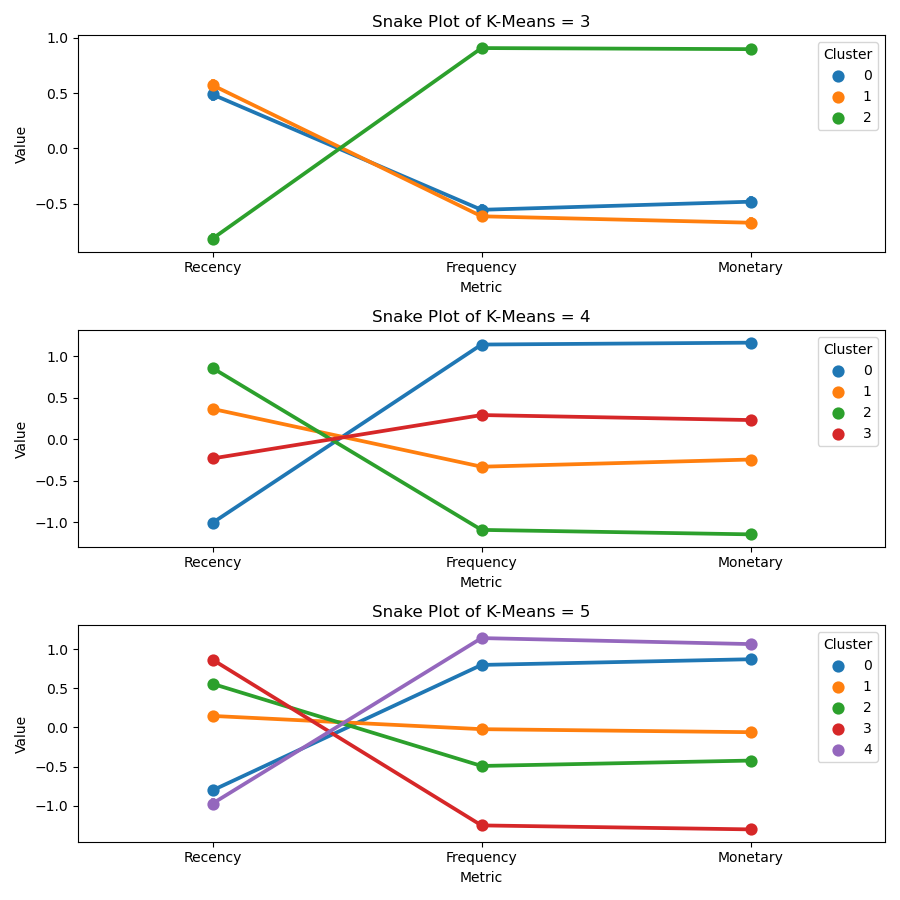

In [263]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(rfm_v_data_scaled, df_rfm_k3, rfm_v_data)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(rfm_v_data_scaled, df_rfm_k4, rfm_v_data)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(rfm_v_data_scaled, df_rfm_k5, rfm_v_data)

plt.tight_layout()

### Interpretation of the clusters formed using k-means

In [264]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [265]:
rfm_values(df_rfm_k3)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         285.0      37.0    719.0  1741
1         308.0      36.0    548.0  1809
2          50.0     292.0   6245.0  2298

In [266]:
rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          33.0     391.0   8885.0  1373
1         249.0      47.0    911.0  1565
2         394.0      17.0    262.0  1367
3         125.0     109.0   1692.0  1543

In [267]:
rfm_values(df_rfm_k5)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          51.0     245.0   5344.0  1184
1         192.0      67.0   1029.0  1409
2         296.0      37.0    702.0  1315
3         402.0      13.0    206.0  1035
4          34.0     391.0   8486.0   905